## Notebook contents: logistic regression, RFLR, HMM, FQ-learning models fit to 2ABT data
This notebook provides an overview of fitting and predicting mouse behavior in a two-armed bandit using descriptive, algorithmic, and theoretical models.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plot_models_v_mouse as bp
import model_policies as models
from sklearn.model_selection import train_test_split
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit

# Load in data and train-test-split

In [15]:
data = pd.read_csv(os.path.join('photometry_trials9010inter_model_data.csv'))
data.head()

,Unnamed: 0.1,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,...,blockchg,blockID,blockLength,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,0,0,sstflp15,07232019_sstflp15,11,11,8,7,7,1,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-51,mouse,True
1,1,1,sstflp15,07232019_sstflp15,12,12,9,8,8,0,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-50,mouse,True
2,2,2,sstflp15,07232019_sstflp15,13,13,10,9,9,0,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-49,mouse,True
3,3,3,sstflp15,07232019_sstflp15,14,14,11,10,10,1,...,1.0,1.0,62,111.0,111.0,AAA,LLL,-48,mouse,True
4,4,4,sstflp15,07232019_sstflp15,15,15,12,11,11,1,...,1.0,1.0,62,111.0,111.0,AAA,LLL,-47,mouse,True


In [14]:
data.shape

(0, 80)

In [16]:
# add "Target" column to data
data['Condition'] = '9010'
data.loc[data['Higher p port']==1, 'Target'] = data['Decision']
data.loc[data['Higher p port']==0, 'Target'] = data['Decision']+1
data.loc[data['Target']==2, 'Target'] = 0
data['Session']=data['Session ID']
data.tail()

,Unnamed: 0.1,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,...,blockchg,blockID,blockLength,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
37827,37827,691,sstflp25,04142021_sstflp25,702,54,45,53,15,1,...,1.0,640.0,59,111.0,111.0,AAA,LLL,-5,mouse,True
37828,37828,692,sstflp25,04142021_sstflp25,703,55,46,54,16,1,...,1.0,640.0,59,111.0,111.0,AAA,LLL,-4,mouse,True
37829,37829,693,sstflp25,04142021_sstflp25,704,56,47,55,17,1,...,1.0,640.0,59,111.0,111.0,AAA,LLL,-3,mouse,True
37830,37830,694,sstflp25,04142021_sstflp25,705,57,48,56,18,1,...,1.0,640.0,59,111.0,111.0,AAA,LLL,-2,mouse,True
37831,37831,695,sstflp25,04142021_sstflp25,706,58,49,57,19,1,...,1.0,640.0,59,111.0,111.0,AAA,LLL,-1,mouse,True


In [ ]:
data['blockTrial']=data['Block Trial']
data['blockchg']=data['blockTrial'].diff()
data.loc[0,'blockchg']=1

In [ ]:
data.loc[data.blockchg!=1.0, 'blockID'] = np.arange(2,np.sum(data.blockchg!=1.0)+2)
data.blockID.ffill(inplace=True)
data.blockID.fillna(value=1, inplace=True)
block_lengths = data.groupby('blockID').apply(lambda x: x['blockTrial'].max()).values.astype('int')+1
data['blockLength']=''

In [ ]:
for i in range(len(data)):
        data['blockLength'][i]=block_lengths[int(data.loc[i, "blockID"])-1]

In [19]:
data.head(115)

,Unnamed: 0.1,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,...,blockchg,blockID,blockLength,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,0,0,sstflp15,07232019_sstflp15,11,11,8,7,7,1,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-51,mouse,True
1,1,1,sstflp15,07232019_sstflp15,12,12,9,8,8,0,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-50,mouse,True
2,2,2,sstflp15,07232019_sstflp15,13,13,10,9,9,0,...,1.0,1.0,62,NaN,NaN,NaN,NaN,-49,mouse,True
3,3,3,sstflp15,07232019_sstflp15,14,14,11,10,10,1,...,1.0,1.0,62,111,111,AAA,LLL,-48,mouse,True
4,4,4,sstflp15,07232019_sstflp15,15,15,12,11,11,1,...,1.0,1.0,62,111,111,AAA,LLL,-47,mouse,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,110,110,sstflp15,07232019_sstflp15,121,59,48,57,-1,0,...,1.0,2.0,61,000,010,aAa,rRr,-2,mouse,True
111,111,111,sstflp15,07232019_sstflp15,122,60,49,58,1,0,...,1.0,2.0,61,000,101,AaA,RrR,-1,mouse,True
112,112,112,sstflp15,07232019_sstflp15,123,0,50,59,2,0,...,-60.0,3.0,91,000,011,aAA,rRR,-91,mouse,False
113,113,113,sstflp15,07232019_sstflp15,124,1,0,60,-1,0,...,1.0,3.0,91,000,110,AAa,RRr,-90,mouse,False


In [ ]:
data.to_csv(path_or_buf='photometry_trials8020_model_data.csv')

In [17]:
probs='9010' # P(high)-P(low)
seq_nback=3 # history length for conditional probabilites
train_prop=0.7 # for splitting sessions into train and test
seed = np.random.randint(1000) # set seed for reproducibility

data = data.loc[data.Condition==probs] # segment out task condition

In [18]:
data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

train_session_ids, test_session_ids = train_test_split(data.Session.unique(), 
                                                       train_size=train_prop, random_state=seed) # split full df for train/test

data['block_pos_rev'] = data['blockTrial'] - data['blockLength'] # reverse block position from transition
data['model']='mouse'
data['highPort'] = data['Decision']==data['Target'] # boolean, chose higher probability port

train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

bpos_mouse = bp.get_block_position_summaries(block_pos_core)
bpos_mouse['condition'] = 'mouse'

In [35]:
block_pos_core

,Unnamed: 0.1,Unnamed: 0,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,...,blockchg,blockID,blockLength,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,22149,0,sstflp16,09092019_sstflp16,11,11,8,9,5,0,...,-14.0,373.0,62,NaN,NaN,NaN,NaN,-51,mouse,True
1,22150,1,sstflp16,09092019_sstflp16,12,12,9,10,6,1,...,1.0,373.0,62,NaN,NaN,NaN,NaN,-50,mouse,True
2,22151,2,sstflp16,09092019_sstflp16,13,13,10,11,7,1,...,1.0,373.0,62,NaN,NaN,NaN,NaN,-49,mouse,True
3,22152,3,sstflp16,09092019_sstflp16,14,14,11,12,8,1,...,1.0,373.0,62,111,111,AAA,LLL,-48,mouse,True
4,22153,4,sstflp16,09092019_sstflp16,15,15,12,13,9,1,...,1.0,373.0,62,111,111,AAA,LLL,-47,mouse,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11380,16406,277,sstflp15,07172019_sstflp15,288,21,10,1,1,0,...,1.0,276.0,26,101,101,AbA,LrL,-5,mouse,False
11381,16407,278,sstflp15,07172019_sstflp15,289,22,10,1,-1,1,...,1.0,276.0,26,010,010,aBa,rLr,-4,mouse,True
11382,16408,279,sstflp15,07172019_sstflp15,290,23,11,1,1,1,...,1.0,276.0,26,101,101,AbA,LrL,-3,mouse,False
11383,16409,280,sstflp15,07172019_sstflp15,291,24,11,1,-1,1,...,1.0,276.0,26,010,010,aBa,rLr,-2,mouse,True


# Plot conditional switch probabilities for just the mouse behavior first
Sort held out conditioned history sequences by full dataset P(switch|sequence)

In [38]:
# full dataset for sorting
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=False, 
                                                        action=['Switch']).sort_values('pswitch')

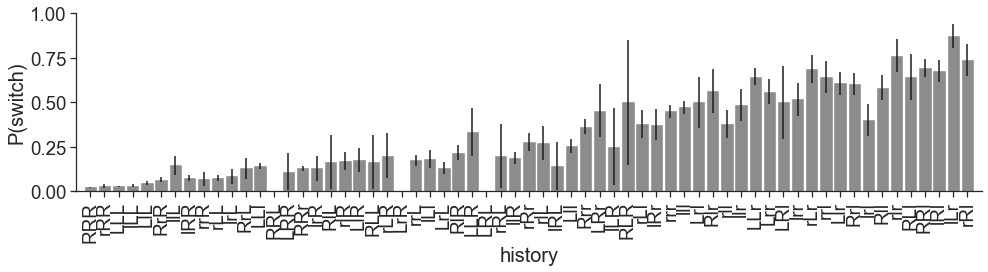

In [39]:
# change TRUE/FALSE for symm asymm
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=False, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
bp.plot_sequences(df_mouse_symm, alpha=0.5) 


#fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/pswitch_syll_3_7030.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)

In [42]:

df_mouse_symm[0:20]

,history,pdecision,n,pdecision_err,pswitch,pswitch_err
20,RRR,0.022530,3107,0.002662,0.022530,0.002662
52,rRR,0.029508,305,0.009690,0.029508,0.009690
0,LLL,0.971840,3125,0.002959,0.028160,0.002959
31,lLL,0.967638,309,0.010067,0.032362,0.010067
8,LlL,0.954128,327,0.011569,0.045872,0.011569
28,RrR,0.065282,337,0.013456,0.065282,0.013456
39,llL,0.853659,41,0.055199,0.146341,0.055199
36,lRR,0.073913,230,0.017251,0.073913,0.017251
60,rrR,0.069767,43,0.038850,0.069767,0.038850
47,rLL,0.926724,232,0.017108,0.073276,0.017108


In [45]:
df_mouse_symm.to_csv(path_or_buf='symm_data.csv')

In [3]:
symmL = pd.read_csv(os.path.join('symm_data_L.csv'))
symmL.head()

,Unnamed: 0,history,pdecision,n,pdecision_err,pswitch,pswitch_err
0,0,LLL,0.971840,3125,0.002959,0.028160,0.002959
1,31,lLL,0.967638,309,0.010067,0.032362,0.010067
2,8,LlL,0.954128,327,0.011569,0.045872,0.011569
3,39,llL,0.853659,41,0.055199,0.146341,0.055199
4,36,lRR,0.073913,230,0.017251,0.073913,0.017251


In [4]:
symm = pd.read_csv(os.path.join('symm_data.csv'))
symm.head()

,Unnamed: 0,history,pdecision,n,pdecision_err,pswitch,pswitch_err
0,20,RRR,0.022530,3107,0.002662,0.022530,0.002662
1,52,rRR,0.029508,305,0.009690,0.029508,0.009690
2,28,RrR,0.065282,337,0.013456,0.065282,0.013456
3,60,rrR,0.069767,43,0.038850,0.069767,0.038850
4,47,rLL,0.926724,232,0.017108,0.073276,0.017108


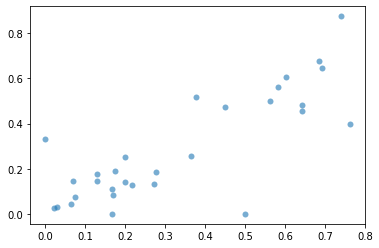

In [5]:
plt.scatter(symm.pswitch, symmL.pswitch, alpha=0.6, edgecolor=None, linewidth=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


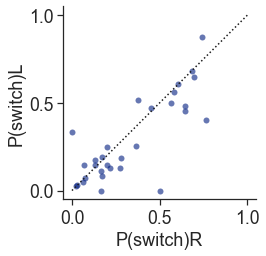

In [9]:
bp.plot_scatter(symm, symmL)
plt.xlabel('P(switch)R')
plt.ylabel('P(switch)L')
fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/90_10_symmetry.eps'
plt.savefig(fig_name, format='eps', dpi=1000)

# Fit models on training data, predict choice probabilities for held-out data
Model predictions (`model_probs`) for each held out session stored for plotting below.

## Logistic regression
Fit logistic regression on training set, with coefficients for choice history (up to trial n-L1), choice-reward interaction (up to trial n-L2), and reward history (up to trial n-L3).

In [ ]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
L3 = 0
memories = [L1, L3, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

## Recursively formulated logistic regression (RFLR)

In [ ]:
params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
alpha, beta, tau = params
print(f'alpha = {alpha[0]:.2f}')
print(f'beta = {beta[0]:.2f}')
print(f'tau = {tau[0]:.2f}')

model_probs = models.RFLR(test_features, params)

## Hidden Markov model (HMM)

In [ ]:
q = 0.98 # 1-p(block transition)
p = 0.8 # p(reward | high port)

model_probs = models.compute_hmm_probs(test_features, parameters={'q':q, 'p':p})

## forgetting Q-learning model (F-Q model)
Using $\alpha$, $\beta$, and $\tau$ parameters derived from fit RFLR above.

In [ ]:
T = (1-np.exp(-1/tau))/beta 
k = 1-np.exp(-1/tau) 
a = alpha 

model_probs = models.fq_learning_model(test_features, parameters=[a, k, T])

# Predict action and plot
Apply policy ('greedy', 'stochastic', or 'softmax') to select actions from `model_probs` and plot behavior. Can add replicate runs for stochastic policies.

In [ ]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)
#fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/pswitch_syll_3_7030_mouse_model1.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)

symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model')
#fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/pswitch_syll_3_7030_mouse_model2.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)

bp.plot_scatter(df_mouse_symm, symm_cprobs_model)

#fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/pswitch_syll_3_7030_mouse_model3.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)

In [ ]:
bpos_model_v_mouse.head(60)

In [ ]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(data, subset='Mouse ID', color_dict = color_dict)
#fig_name = 'D:/Dropbox (Personal)/BUSM/manuscripts/EP_2abt/figs from jupyter/pswitch_syll_3_7030_mouse_model1.eps'
#plt.savefig(fig_name, format='eps', dpi=1000)